# Исследование признаков

* Делаем предварительный отбор 50 лучших признаков
* Кластеризация
* Выбираем лучшие признаки из кластеров
* Строим на них модель

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../eeg-research/')

from os.path import join

import pipeline.features
import pipeline.models

base_path = '../own_data/191104_depr_splits_features/'

/Users/ledovsky/anaconda3/lib/python3.7/site-packages/numba/decorators.py:146: RuntimeWarning: Caching is not available when the 'parallel' target is in use. Caching is now being disabled to allow execution to continue.
  warnings.warn(msg, RuntimeWarning)


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams["font.family"] = "Times New Roman"

In [3]:
from sklearn.metrics import roc_auc_score

In [4]:
def plot_curves(hist):
    pal = sns.color_palette('Set2')
    
    fig = plt.figure(figsize=[8, 4])
    l1, = plt.plot(hist.index, hist['score'], 
                   label='First timeframe, ROC-AUC = {:.2f}'.format(hist['score'].iloc[-1]),
                   color=pal[2])
    l2, = plt.plot(hist.index, hist['score_val'], 
                   label='Second (control) timeframe, ROC-AUC = {:.2f}'.format(hist['score_val'].iloc[-1]),
                   color=pal[1])
    
    lb = hist['score'] - hist['score_std'] * 1.96
    ub = hist['score'] + hist['score_std'] * 1.96
    plt.fill_between(hist.index, lb, ub, alpha=0.5, color=pal[2])
    lb = hist['score_val'] - hist['score_val_std'] * 1.96
    ub = hist['score_val'] + hist['score_val_std'] * 1.96
    plt.fill_between(hist.index, lb, ub, alpha=0.5, color=pal[1])
    plt.xlabel('Feature selection step')
    plt.ylabel('ROC-AUC')
    plt.ylim([0.5, 1.0])
    plt.legend(loc=0)
    return fig

In [5]:
def plot_roc_curve(y_true, y_pred, title=None, auc=None, save_path=None):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    
    if auc is None:
        auc = roc_auc_score(y_true, y_pred)
        
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (average area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    if title is not None:
        plt.title(title)
    plt.legend(loc="lower right")
    if save_path:
        plt.savefig(save_path, transparent=True, dpi=150)

In [6]:
feature_methods = [
    'env-alpha',
    'env-beta',
    'coh-alpha',
    'coh-beta',
    'bands'
]


In [7]:
dir_1 = '30s_1_0_30'
dir_2 = '30s_1_30_60'
dir_3 = '30s_0_30_60'
dir_4 = '30s_0_0_30'
dir_0 = '60s_1_0_60'

df_0 = pipeline.features.get_merged_df(join(base_path, dir_0), feature_methods)
df_1 = pipeline.features.get_merged_df(join(base_path, dir_1), feature_methods)
df_2 = pipeline.features.get_merged_df(join(base_path, dir_2), feature_methods)
df_3 = pipeline.features.get_merged_df(join(base_path, dir_3), feature_methods)
df_4 = pipeline.features.get_merged_df(join(base_path, dir_4), feature_methods)

In [8]:
features = [col for col in df_1.columns if col not in ['fn', 'target']]
model = pipeline.models.LRScaled()

In [9]:
from scipy import stats

In [10]:
from sklearn.metrics import roc_auc_score

## Измеряем перформанс признаков

In [11]:
def get_scores(feat, neg=False):
    rows = []
    sign = 1 if neg is False else -1
#     for i, df in enumerate([df_1, df_2, df_3, df_4, df_0]):
    for i, df in enumerate([df_1, df_2]):
        rows.append((i + 1, feat, roc_auc_score(df['target'], sign * df[feat].fillna(0))))
    return pd.DataFrame(rows, columns=['dataframe', 'feature', 'roc_auc'])

In [12]:
dfs = []
for feat in features:
    dfs.append(get_scores(feat).groupby('feature')['roc_auc'].aggregate(['mean', 'min', 'max']))
df_feats_performance = pd.concat(dfs)
df_feats_performance['sign'] = 'pos'

In [13]:
def swap(row):
    if row['mean'] < 0.48:
        row['mean'], row['max'], row['min'] = 1 - row['mean'], 1 - row['min'], 1 - row['max']
        row['sign'] = 'neg'
    return row

In [14]:
df_feats_performance = df_feats_performance.apply(swap, axis=1)

In [15]:
df_feats_performance = df_feats_performance.sort_values('min', ascending=False)

In [16]:
pd.set_option('display.max_rows', 100)

In [17]:
df_feats_performance.reset_index(inplace=True)
df_feats_performance['chs'] = df_feats_performance['feature'].apply(lambda s: s.split('_', maxsplit=2)[-1])
df_feats_performance.set_index('feature', inplace=True)

In [18]:
df_feats_performance['paired'] = df_feats_performance['chs'].apply(lambda s: True if '_' in s else False)

In [19]:
df_feats_performance

,mean,min,max,sign,chs,paired
feature,,,,,,
coh_alpha_t6_c3,0.760354,0.739899,0.780808,neg,t6_c3,True
env_alpha_c4_fz,0.762121,0.735354,0.788889,neg,c4_fz,True
env_alpha_c4_f3,0.727020,0.723737,0.730303,neg,c4_f3,True
env_alpha_c4_fp2,0.747980,0.721717,0.774242,neg,c4_fp2,True
coh_alpha_f4_c3,0.732071,0.720202,0.743939,neg,f4_c3,True
...,...,...,...,...,...,...
coh_beta_p4_f3,0.488384,0.453535,0.523232,pos,p4_f3,True
coh_beta_c4_t5,0.487879,0.452525,0.523232,pos,c4_t5,True
env_beta_o2_fp1,0.482828,0.438889,0.526768,pos,o2_fp1,True


## Предварительный отбор признаков

In [20]:
from scipy import stats

In [21]:
top_features = df_feats_performance.drop_duplicates('chs').head(50).index.tolist()

In [22]:
rows = []
for feat in top_features:
    mw = stats.mannwhitneyu(
        df_1[df_1['target'] == 1][feat], 
        df_1[df_1['target'] == 0][feat], 
        alternative='less')[1]
    roc_auc = roc_auc_score(df_1['target'], -df_1[feat])
    roc_auc = max(roc_auc, 1 - roc_auc)
    mw = min(mw, 1 - mw)
    rows.append((feat, roc_auc, mw))
    
df_top_feats = pd.DataFrame(rows, columns=['feature', 'roc_auc', 'p_val'])


## Кластеризация

In [23]:
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [24]:
X = df_1[top_features]
corr = X.corr()
dist_vector = squareform(1 - corr)

In [25]:
l_single = linkage(dist_vector, method='single')

In [26]:
l_compl = linkage(dist_vector, method='complete')

In [27]:
l_aver = linkage(dist_vector, method='average')

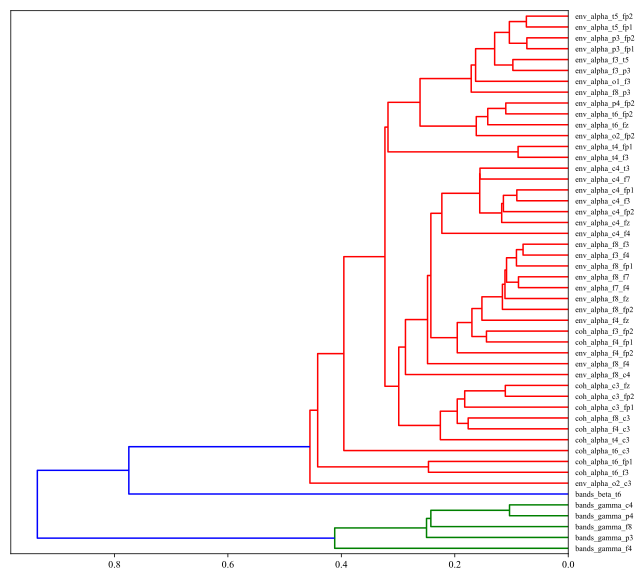

In [28]:
fig, axes = plt.subplots(figsize=[10, 10])
dendrogram(l_single, labels=top_features, orientation='left');

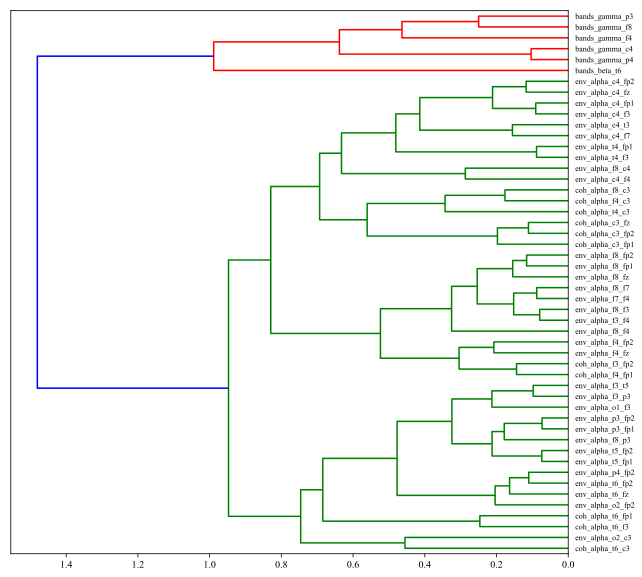

In [29]:
fig, axes = plt.subplots(figsize=[10, 10])
dendrogram(l_compl, labels=top_features, orientation='left');

## Выбираем эту дендрограмму

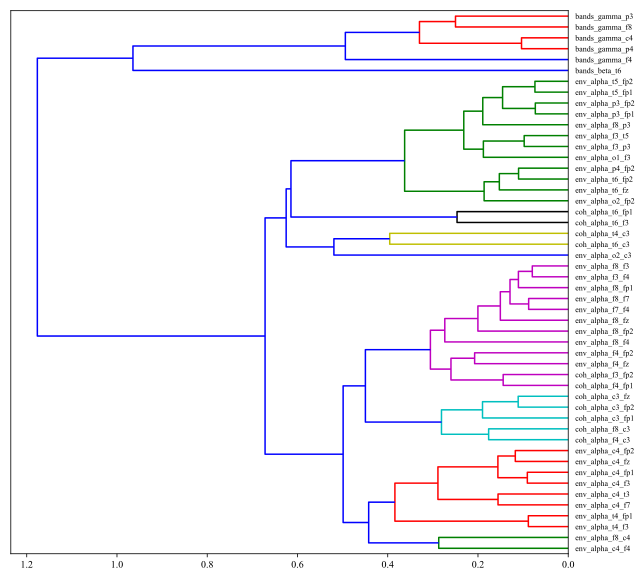

In [30]:
fig, axes = plt.subplots(figsize=[10, 10])
dendrogram(l_aver, labels=top_features, orientation='left', color_threshold=0.4);
fig.savefig('dendrogram.png', dpi=200, transparent=True, bbox_inches='tight')

In [31]:
df_feats_performance['cluster'] = -1
df_feats_performance.loc[top_features, 'cluster'] = fcluster(l_aver, t=0.4, criterion='distance')

In [32]:
top_feats_from_clusters = df_feats_performance[df_feats_performance['cluster'] > -1].drop_duplicates('cluster').index.tolist()

## Перформанс отобранных признаков от кластеров

In [33]:
rows = []
for feat in top_feats_from_clusters:
    mw = stats.mannwhitneyu(
        df_1[df_1['target'] == 1][feat], 
        df_1[df_1['target'] == 0][feat], 
        alternative='less')[1]
    roc_auc = roc_auc_score(df_1['target'], -df_1[feat])
    roc_auc = max(roc_auc, 1 - roc_auc)
    mw = min(mw, 1 - mw)
    rows.append((feat, roc_auc, mw))
    
df_top_feats = pd.DataFrame(rows, columns=['feature', 'roc_auc', 'p_val'])


In [34]:
df_top_feats

,feature,roc_auc,p_val
0,coh_alpha_t6_c3,0.739899,0.000049
1,env_alpha_c4_fz,0.735354,0.000067
2,coh_alpha_f4_c3,0.743939,0.000038
3,env_alpha_f3_f4,0.717677,0.000206
4,env_alpha_c4_f4,0.743939,0.000038
5,env_alpha_t6_fp2,0.691919,0.000922
6,bands_gamma_p4,0.696465,0.000696
7,coh_alpha_t6_f3,0.683838,0.001428
8,bands_gamma_f4,0.672222,0.002536
9,env_alpha_o2_c3,0.668182,0.003181


In [35]:
len(top_feats_from_clusters)

11

## Корреляция топ признаков от кластеров

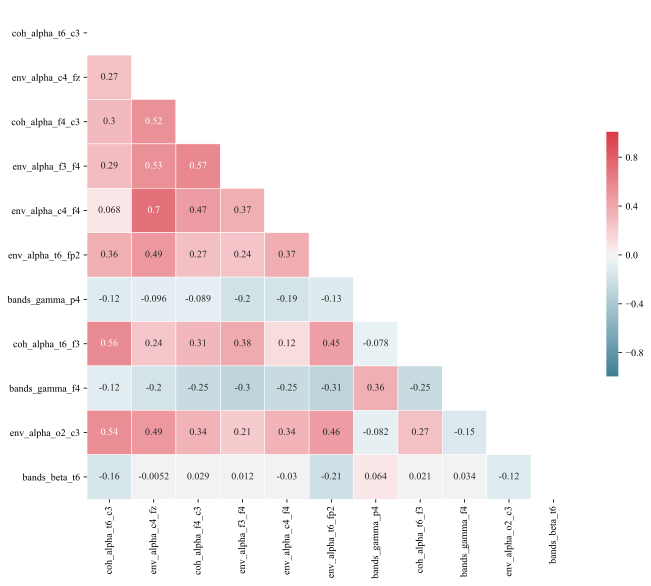

In [36]:
X = df_1[top_feats_from_clusters]
# corr = scipy.stats.spearmanr(X)[0]
corr = X.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

f.savefig('top_clust_feats_corr.png', dpi=200, transparent=True, bbox_inches='tight')

## Тест модели на отобранных признаках

In [37]:
def order_func(features, df):
    return features
res = pipeline.models.select_features(df_1, top_feats_from_clusters, pipeline.models.LRScaled(C=10), order_func=order_func, df_val=df_2)

Feature selection. Step 1



Feature selection. Step 2


In [38]:
res[2]

,feature,action,score,score_std,score_val,score_val_std
0,coh_alpha_t6_c3,added,0.686919,0.019807,0.731010,0.021591
1,env_alpha_c4_fz,added,0.741869,0.009608,0.794975,0.008650
2,coh_alpha_f4_c3,added,0.762601,0.010754,0.796465,0.009652
3,env_alpha_c4_f4,added,0.776414,0.009628,0.783889,0.010494
4,bands_gamma_p4,added,0.788535,0.011292,0.806162,0.010606
5,env_alpha_c4_f4,removed,0.800303,0.012029,0.815480,0.009476


## Почему ROC-AUC и Mann-Whithey U одно и то же

In [39]:
from scipy import stats
import statsmodels.api as sm

/Users/ledovsky/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [40]:
roc_auc_score(df_1['target'], df_1['coh_alpha_c4_fz'])

0.2050505050505051

In [41]:
stats.mannwhitneyu(
    df_1[df_1['target'] == 1]['coh_alpha_c4_fz'], 
    df_1[df_1['target'] == 0]['coh_alpha_c4_fz'], 
    alternative='less')                       

MannwhitneyuResult(statistic=406.0, pvalue=8.411721907136107e-07)

In [42]:
406.0 / (df_1['target'] == 1).sum() / (df_1['target'] == 0).sum()

0.20505050505050504